In [1]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
from sklearn.linear_model import RidgeCV
from scipy.interpolate import LinearNDInterpolator
from scipy.stats import sem, pearsonr
from my_utils import *

from pathlib import Path
import sys

In [2]:
modelpath = Path('../model')
sys.path.append(str(modelpath))
import config.config as config

arg = config.ConfigPerturb()
arg.device = 'cpu'

In [3]:
# agents checkpoints path
progress_agents_path = Path('../data/agents')
# agents checkpoints performance path
training_curve_path = Path('../data/training_curve')
# figure path
figure_path = Path('../paper_figures/figure6')

# Select agent checkpoints for analyses

In [4]:
def select_agents(progress_agents_path, agent_archs, MAX_TRAINING_T, task='perturbation'):
    perform_files = [[pd.read_csv(file)[(pd.read_csv(file).episode > 0) & (pd.read_csv(file).episode < MAX_TRAINING_T)] 
                      for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
                     for agent_arch in agent_archs]
    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    best_seeds = [seed[np.argmax([np.sum([file[file.task == task].reward_rate 
                                          for task in file.task.unique()], axis=0).max()
                                  for file in perform_file])] 
                  for perform_file, seed in zip(perform_files, seeds)]
    best_files_idx = [np.argmax([np.sum([file[file.task == task].reward_rate 
                                         for task in file.task.unique()], axis=0).max()
                                 for file in perform_file]) 
                      for perform_file in perform_files]
    
    best_paths = [progress_agents_path / agent_arch / 'gain' / f'seed{seed}'
                  for agent_arch, seed in zip(agent_archs, best_seeds)]
    
    best_files = [perform_file[file_idx] for perform_file, file_idx in zip(perform_files, best_files_idx)]
    best_episodes = [file.episode.unique()[np.sum([file[file.task == task].reward_rate 
                                                   for task in file.task.unique()], axis=0).argmax()] 
                     for file in best_files]

    best_agents = [list(best_path.glob(f'*-{best_episode}.*'))[0].stem.split('.')[0]
                   for best_path, best_episode in zip(best_paths, best_episodes)]
    
    return best_seeds, best_paths, best_agents, perform_files

In [5]:
Models = {'Holistic_Actor': 'Actor1', 'Holistic_Critic': 'Critic1',
          'Modular_Actor': 'Actor3', 'Modular_Critic': 'Critic5'}
for k, v in Models.items():
    exec(f'from {v} import {v[:-1]} as {k}')

agent_archs = [Models['Holistic_Actor'] + Models['Holistic_Critic'], 
               Models['Modular_Actor'] + Models['Holistic_Critic'],
               Models['Holistic_Actor'] + Models['Modular_Critic'],
               Models['Modular_Actor'] + Models['Modular_Critic']]

MAX_TRAINING_T = 1e4
task = 'perturbation'

In [6]:
best_seeds, best_paths, best_agents, perform_files = select_agents(progress_agents_path, 
                                                                   agent_archs, 
                                                                   MAX_TRAINING_T=MAX_TRAINING_T,
                                                                   task=task)

In [7]:
def select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, task='perturbation'):    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    
    agent_paths = []; agent_files = []
    for agent_arch, seeds_ in zip(agent_archs, seeds): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / task / f'{agent_arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                      for task in perform_file.task.unique()], axis=0).argmax()]
            
            agent_path.append(progress_agents_path / agent_arch / 'gain' / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    
    return agent_paths, agent_files

In [8]:
agent_paths, agent_files = select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, task='perturbation')

# Run agents

In [9]:
from Agent_RNN import *
from Environment import Env

In [10]:
def RNN_agent_simulation(arg, agent, target_positions, perturb_peaks, perturb_start_time_oris):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []; pos_theta = []; pos_r_end = []; pos_theta_end = []
    pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []; steps = []
    perturb_v = []; perturb_w = []; perturb_v_gauss = []; perturb_w_gauss = []
    state_ = []; action_ = []

    for target_position, perturb_peak, perturb_start_time_ori in zip(target_positions, perturb_peaks,
                                                                     perturb_start_time_oris):
        cross_start_threshold = False
        x = env.reset(target_position=target_position, perturbation_velocities=perturb_peak,
                      perturbation_start_t=perturb_start_time_ori)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position.view(1, 1, -1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        perturbations = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
            
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)

            true_states.append(x)
            states.append(state)
            actions.append(action)
            perturbations.append(torch.stack((env.perturbation_vt, env.perturbation_wt)))
            
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

            if is_stop and cross_start_threshold:
                break

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))
        
        state_.append(torch.cat(states))

        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions).squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())
        
        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))
        
        perturb_v.append(torch.stack(perturbations)[:, 0].numpy() * arg.LINEAR_SCALE)
        perturb_w.append(np.rad2deg(torch.stack(perturbations)[:, 1].numpy()))
        perturb_v_gauss.append(env.gaussian_v_array.numpy() * arg.LINEAR_SCALE)
        perturb_w_gauss.append(np.rad2deg(env.gaussian_w_array.numpy()))
        
    agent.bstep.obs_noise_range = config.ConfigGain().obs_noise_range

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end, steps=steps,
                                 perturb_v=perturb_v, perturb_w=perturb_w,
                                 perturb_vpeak=torch.stack(perturb_peaks)[:, 0].numpy() * arg.LINEAR_SCALE,
                                 perturb_wpeak=np.rad2deg(torch.stack(perturb_peaks)[:, 1].numpy()),
                                 perturb_start_time=torch.stack(perturb_start_time_oris).numpy(),
                                 perturb_v_gauss=perturb_v_gauss, perturb_w_gauss=perturb_w_gauss,
                                 gain_v=[env.process_gain_default[0].item() for _ in range(len(pos_x))],
                                 gain_w=[env.process_gain_default[1].item() for _ in range(len(pos_x))],
                                 state=state_, action=action_))

In [11]:
models_ = dict([(v, k) for k, v in Models.items()])
agents = []
for idx, agent_arch in enumerate(agent_archs):
    filename = best_agents[idx]
    agent = Agent(arg, eval(models_[agent_arch[:6]]), eval(models_[agent_arch[6:]]))
    agent.data_path = best_paths[idx]
    agent.load(filename, load_memory=False, load_optimzer=False)
    agents.append(agent)

In [12]:
SAMPLE_SIZE = 5000
reset_seeds(0)
perturb_peaks_null = [torch.zeros(2) for _ in range(SAMPLE_SIZE)]

arg = config.ConfigPerturb(exclude_perturb=np.hstack([np.array([-100, 100]) / arg.LINEAR_SCALE, 
                                                      np.deg2rad([-60, 60])]))
arg.device = 'cpu'
env = Env(arg)
target_positions = []
perturb_peaks_large = []
perturb_start_time_oris = []
for _ in range(SAMPLE_SIZE):
    __ = env.reset()
    target_positions.append(env.target_position)
    perturb_peaks_large.append(env.perturbation_velocities)
    perturb_start_time_oris.append(env.perturbation_start_t)
    
arg = config.ConfigPerturb()
arg.device = 'cpu'
env = Env(arg)
perturb_peaks_full = []
for _ in range(SAMPLE_SIZE):
    __ = env.reset()
    perturb_peaks_full.append(env.perturbation_velocities)

In [13]:
agent_trajectories = []
for agent in agents:
    traj = []
    for perturb_peaks in [perturb_peaks_null, perturb_peaks_full, perturb_peaks_large]:
        traj.append(RNN_agent_simulation(arg, agent, target_positions, 
                                          perturb_peaks, perturb_start_time_oris))
    agent_trajectories.append(traj)

In [14]:
agents_all = []
for idx, agent_arch in enumerate(agent_archs):
    agents_ = []
    for agent_path, agent_file in zip(agent_paths[idx], agent_files[idx]):
        agent = Agent(arg, eval(models_[agent_arch[:6]]), eval(models_[agent_arch[6:]]))
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
    agents_all.append(agents_)

In [15]:
agent_trajectories_all = []
for agents_ in agents_all:
    traj = []
    for perturb_peaks in [perturb_peaks_null, perturb_peaks_full, perturb_peaks_large]:
        traj.append([RNN_agent_simulation(arg, agent, target_positions, perturb_peaks, 
                                           perturb_start_time_oris) 
                     for agent in agents_])
    agent_trajectories_all.append(traj)    

# Figures

In [16]:
locals().update(config_colors())
major_formatter = FuncFormatter(my_tickformatter)

fontsize = 7
lw = 1

## 6f

In [18]:
def get_neural_response(agent, df):
    responses = []
    with torch.no_grad():
        for _, trial in df.iterrows():
            response = agent.actor.rnn(trial.state)[0]
            responses.append(response.squeeze(1))
        df['response'] = responses
    return torch.cat(responses).numpy()

In [19]:
_ = [[get_neural_response(agent, df) for df in dfs] for agent, dfs in zip(agents, agent_trajectories)]

In [20]:
train_frac = 0.7
def fit_decoder(trajectory, start_idx=0, variables=['pos_x', 'pos_y']):
    key = 'response'
    train_trajectory = trajectory[:round(len(trajectory) * train_frac)]
    train_X = np.vstack([x[start_idx:] for _, x in train_trajectory[key].iteritems()])
    test_trajectory = trajectory[round(len(trajectory) * train_frac):]
    test_X = np.vstack([x[start_idx:] for _, x in test_trajectory[key].iteritems()])
    
    y = train_trajectory[variables].values
    train_y = np.vstack([np.hstack([v[start_idx:] for v in y[:, i]]) for i in range(y.shape[1])]).T
    y = test_trajectory[variables].values
    test_y = np.vstack([np.hstack([v[start_idx:] for v in y[:, i]]) for i in range(y.shape[1])]).T
    
    decoder = RidgeCV()
    decoder.fit(train_X, train_y)
    
    return decoder, test_X, test_y

In [21]:
decoders = [list(map(fit_decoder, trajectories)) for trajectories in agent_trajectories]

In [22]:
agent_indices = [0, 3]
trial_indices = [15]

data_x = []; data_y = []
for agent_idx, trial_idx in cartesian_prod(agent_indices, trial_indices):
    decoder = decoders[agent_idx][-1]
    trajectory = agent_trajectories[agent_idx][-1]
    trial = trajectory.iloc[round(len(trajectory) * train_frac) + trial_idx]
    data_x.append(np.vstack(trial[['pos_x', 'pos_y']]))
    data_y.append(decoder[0].predict(trial.response).T)
    
data_target = trial[['target_x', 'target_y']].values

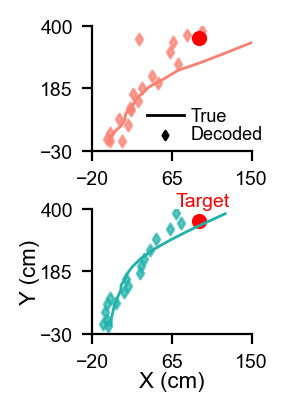

In [23]:
width = 1.35; height = 1.9
title_pad = 3

xmins, xmaxs = [-20] * 2, [150] * 2
xticks = [np.linspace(xmin, xmax, 3) for xmin, xmax in zip(xmins, xmaxs)]
ymins, ymaxs = [-30] * 2, [400] * 2
yticks = [np.linspace(ymin, ymax, 3) for ymin, ymax in zip(ymins, ymaxs)]

with initiate_plot(width, height, 200) as fig:
    for f_idx in range(2):
        ax = fig.add_subplot(2, 1, f_idx + 1)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.xticks(xticks[f_idx], fontsize=fontsize)
        plt.yticks(yticks[f_idx], fontsize=fontsize)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim([xmins[f_idx], xmaxs[f_idx]])
        ax.set_ylim([ymins[f_idx], ymaxs[f_idx]])
        
        x, y = data_x[f_idx], data_y[f_idx]
        c = holistic_c if f_idx == 0 else modular_c
        ax.plot(*x, c=c, lw=lw)
        ax.scatter(*y, c=c, lw=lw, s=8, marker='d', alpha=0.7)
        ax.scatter(*data_target, c='r', lw=lw, s=20)
            
        if f_idx == 1:
            ax.set_xlabel(r'X (cm)', fontsize=fontsize + 1)
            ax.set_ylabel(r'Y (cm)', fontsize=fontsize + 1)
            ax.xaxis.set_label_coords(0.5, -0.3)
            ax.yaxis.set_label_coords(-0.33, 0.5)
            ax.text(data_target[0] - 25, data_target[1] + 50, s='Target', fontsize=fontsize, c='r')

        if f_idx == 0:
            l1 = ax.plot([], [], c='k', lw=lw, label='True')
            s1 = ax.scatter([], [], c='k', lw=lw, s=5, marker='d', label='Decoded')
            ax.legend(fontsize=fontsize-0.5, frameon=False, loc=[0.3, 0], 
                      handletextpad=0.4, labelspacing=0, ncol=1, columnspacing=0.8)
    
    fig.tight_layout(pad=0.1, w_pad=0, h_pad=0.15, rect=(-0.0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='trial_example_decode'), orientation='portrait', format='pdf', transparent=True)

## 6h

In [24]:
_ = [[[get_neural_response(agent, df) for agent, df in zip(agents_, trajectories)] 
      for trajectories in agent_trajectories_] 
     for agents_, agent_trajectories_ in zip(agents_all, agent_trajectories_all)]

In [25]:
start_idx = 0
decoders_all = [[list(map(fit_decoder, [traj for traj in trajectories], [start_idx] * len(trajectories))) 
                 for trajectories in agent_trajectories_] 
                for agent_trajectories_ in agent_trajectories_all]

In [26]:
dfs_roc = [agent_trajectories_all[agent_idx][-1] for agent_idx in range(len(agent_trajectories_all))]

In [27]:
max_reward_boundary = int(max([df.relative_radius_end.max() for dfs in dfs_roc for df in dfs])) + 1; 
hypo_reward_boundaries = np.arange(max_reward_boundary)

targets = dfs_roc[0][0][['target_x', 'target_y']].values[round(train_frac * len(dfs_roc[0][0])):]
shuffled_targets = targets.copy()
rng = default_rng(1); rng.shuffle(shuffled_targets, axis=0)

ydata_subjects = []; xdata_subjects = []
for dfs in dfs_roc:
    ydata_seeds = []; xdata_seeds = []
    for df in dfs:
        ydata = []; xdata = []
        df = df[round(train_frac * len(dfs_roc[0][0])):]
        for reward_boundary in hypo_reward_boundaries:
            ydata.append((np.linalg.norm(np.vstack([[i[-1] for i in df.pos_x], [i[-1] for i in df.pos_y]]).T 
                                         - targets, axis=1) 
                          < reward_boundary).sum() / len(df))
            xdata.append((np.linalg.norm(np.vstack([[i[-1] for i in df.pos_x], [i[-1] for i in df.pos_y]]).T
                                         - shuffled_targets, axis=1) 
                          < reward_boundary).sum() / len(df))
        ydata_seeds.append(ydata); xdata_seeds.append(xdata)
    ydata_subjects.append(ydata_seeds); xdata_subjects.append(xdata_seeds)

In [28]:
auc_data = [[np.trapz(ydata_subjects[agent_idx][idx], xdata_subjects[agent_idx][idx]) for idx in range(8)] 
            for agent_idx in range(len(dfs_roc))]

In [29]:
decoders_roc = [decoders_all[agent_idx][-1] for agent_idx in range(len(decoders_all))]
decoders_error_data = [[np.linalg.norm(decoders_roc[agent_idx][idx][0].predict(decoders_roc[agent_idx][idx][1])
                                       - decoders_roc[agent_idx][idx][2], axis=1).mean()
                        for idx in range(8)] for agent_idx in range(len(decoders_roc))]

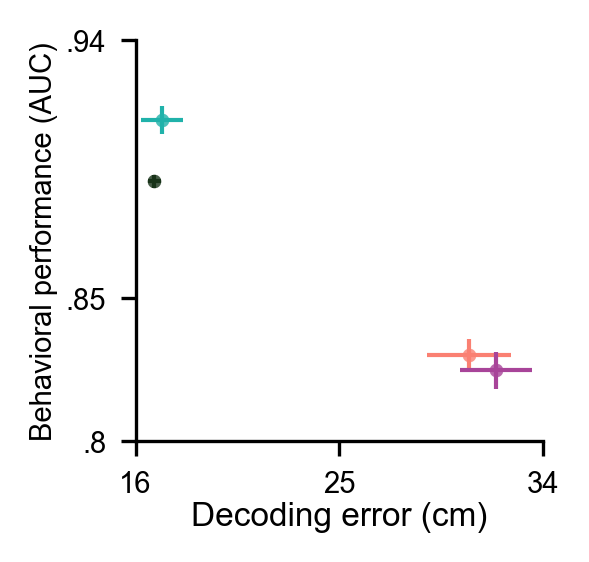

In [30]:
width = 1.8; height = 1.7
marker = 'o'; marker_size = 10; marker_lw = 0.1

yticks = [0.8, 0.85, 0.94]
xticks = np.linspace(16, 34, 3)

colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_ylabel('Behavioral performance (AUC)', fontsize=fontsize)
    ax.set_xlabel('Decoding error (cm)', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.yaxis.set_label_coords(-0.19, 0.5)
    ax.xaxis.set_major_formatter(major_formatter)
    ax.yaxis.set_major_formatter(major_formatter)
          
    for (agent_idx, xdata), ydata in zip(enumerate(decoders_error_data), auc_data):
        xmean = np.mean(xdata); xerr = sem(xdata)
        ymean = np.mean(ydata); yerr = sem(ydata)
        
        ax.scatter(xmean, ymean, c=colors[agent_idx], s=marker_size, lw=marker_lw, marker=marker, alpha=0.8)
        ax.errorbar(xmean, ymean, yerr=yerr, xerr=xerr, c=colors[agent_idx], lw=lw, ls='none') 
        
    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='auc_vs_error'), orientation='portrait', format='pdf', transparent=True)

## 6g

In [31]:
def get_trial_predicted_pos(dfs, decoders):
    for df, decoder in zip(dfs, decoders):
        predicted_poses = []; errors = []
        for _, trial in df.iterrows():
            predicted_pos = decoder[0].predict(trial.response)
            predicted_poses.append(predicted_pos)
            true_pos = np.vstack(trial[['pos_x', 'pos_y']]).T
            errors.append(np.linalg.norm(predicted_pos - true_pos, axis=1).mean())
        df['predicted_pos'] = predicted_poses
        df['mean_decoding_error'] = errors

In [32]:
def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

In [33]:
_ = get_trial_predicted_pos(flatten(agent_trajectories_all), flatten(decoders_all))

In [34]:
start_idx = int(train_frac * len(agent_trajectories[0][0]))
decoding_errors_v = []; perturb_sums_v = []
for agent_idx in range(4):
    decoding_errors_ = []; perturb_sums_ = []
    for seed_idx in range(8):
        for gain_idx in [1]:
            df = agent_trajectories_all[agent_idx][gain_idx][seed_idx].iloc[start_idx:]
            predicted_position = np.vstack([pos[-1] for pos in df.predicted_pos])
            true_position = df[['pos_x_end', 'pos_y_end']].values
            perturb_sum = np.array([v.sum() * arg.DT for v in df.perturb_v])
            decoding_error = np.linalg.norm(predicted_position, axis=1) - np.linalg.norm(true_position, axis=1)
            decoding_errors_.append(decoding_error); perturb_sums_.append(perturb_sum)
    decoding_errors_, perturb_sums_ = map(np.hstack, [decoding_errors_, perturb_sums_])
    decoding_errors_v.append(decoding_errors_); perturb_sums_v.append(perturb_sums_)

In [35]:
decoding_errors_w = []; perturb_sums_w = []
for agent_idx in range(4):
    decoding_errors_ = []; perturb_sums_ = []
    for seed_idx in range(8):
        for gain_idx in [1]:
            df = agent_trajectories_all[agent_idx][gain_idx][seed_idx].iloc[start_idx:]
            predicted_position = np.vstack([pos[-1] for pos in df.predicted_pos])
            true_position = df[['pos_x_end', 'pos_y_end']].values
            perturb_sum = np.array([w.sum() * arg.DT for w in df.perturb_w])
            decoding_error = np.arctan2(predicted_position[:, 1], predicted_position[:, 0]) - \
                             np.arctan2(true_position[:, 1], true_position[:, 0])
            decoding_error = np.rad2deg(decoding_error)
            decoding_errors_.append(decoding_error); perturb_sums_.append(perturb_sum)
    decoding_errors_, perturb_sums_ = map(np.hstack, [decoding_errors_, perturb_sums_])
    decoding_errors_w.append(decoding_errors_); perturb_sums_w.append(perturb_sums_)

0 PearsonRResult(statistic=-0.6669302771862606, pvalue=0.0)
1 PearsonRResult(statistic=-0.6858283905702521, pvalue=0.0)
2 PearsonRResult(statistic=-0.42042706730783963, pvalue=0.0)
3 PearsonRResult(statistic=-0.30257965965348743, pvalue=1.645468593051789e-252)
0 PearsonRResult(statistic=-0.30328552663909514, pvalue=9.738748569793493e-254)
1 PearsonRResult(statistic=-0.30902641335922304, pvalue=7.494885505890112e-264)
2 PearsonRResult(statistic=-0.26110670563245164, pvalue=2.999804602751938e-186)
3 PearsonRResult(statistic=-0.18630434440701468, pvalue=3.590900654022984e-94)


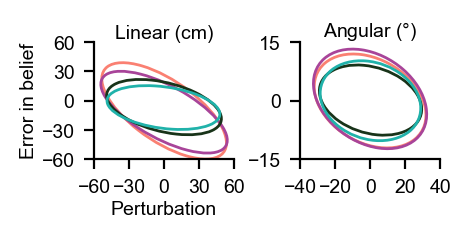

In [36]:
width = 2.2; height = 1.1
xmax = [60, 40]; ymax = [60, 15]; num_ytick = [5, 3]

colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
agent_idces = [0, 1, 2, 3]

with initiate_plot(width, height, 200) as fig:
    for f_idx in range(2):
        ax = fig.add_subplot(1, 2, f_idx + 1)
        if f_idx == 0:
            perturb_sums = perturb_sums_v; decoding_errors = decoding_errors_v
        else:
            perturb_sums = perturb_sums_w; decoding_errors = decoding_errors_w
        for agent_idx in agent_idces:
            ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
            plt.xticks(np.linspace(-xmax[f_idx], xmax[f_idx], 5), fontsize=fontsize)
            plt.yticks(np.linspace(-ymax[f_idx], ymax[f_idx], num_ytick[f_idx]), fontsize=fontsize)
            ax.set_xlabel('', fontsize=fontsize)
            ax.set_ylabel('', fontsize=fontsize)
            ax.set_xlim([-xmax[f_idx], xmax[f_idx]])
            ax.set_ylim([-ymax[f_idx], ymax[f_idx]])

            confidence_ellipse(perturb_sums[agent_idx], decoding_errors[agent_idx], 
                               ax, n_std=1, ec=colors[agent_idx], lw=lw)
            print(agent_idx, pearsonr(perturb_sums[agent_idx], decoding_errors[agent_idx]))
           
        if f_idx == 0:
            ax.set_title('Linear (cm)', fontsize=fontsize, pad=0)
            ax.set_xlabel(r'Perturbation', fontsize=fontsize)
            ax.set_ylabel(r'Error in belief', fontsize=fontsize)
            ax.xaxis.set_label_coords(0.5, -0.35)
            ax.yaxis.set_label_coords(-0.4, 0.5)
        else:
            ax.set_title(r'Angular ($\degree$)', fontsize=fontsize, pad=0)
    
    fig.tight_layout(pad=0.05, w_pad=0.1, rect=(-0.0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='perturb_vs_decoding_error'), orientation='portrait', format='pdf', transparent=True)

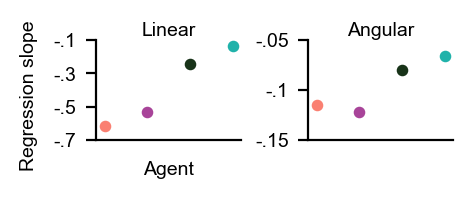

In [37]:
width = 2.2; height = 0.8
ymin = [-0.7, -0.15]; ymax = [-0.1, -0.05]; num_ytick = [4, 3]

colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
agent_idces = [0, 1, 2, 3]

with initiate_plot(width, height, 200) as fig:
    for f_idx in range(2):
        ax = fig.add_subplot(1, 2, f_idx + 1)
        if f_idx == 0:
            perturb_sums = perturb_sums_v; decoding_errors = decoding_errors_v
        else:
            perturb_sums = perturb_sums_w; decoding_errors = decoding_errors_w
        for agent_idx in agent_idces:
            ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
            plt.xticks([], fontsize=fontsize)
            plt.yticks(np.linspace(ymin[f_idx], ymax[f_idx], num_ytick[f_idx]), fontsize=fontsize)
            ax.set_xlabel('', fontsize=fontsize)
            ax.set_ylabel('', fontsize=fontsize)
            ax.set_xlim([-0.2, 3.2])
            ax.set_ylim([ymin[f_idx], ymax[f_idx]])
            ax.yaxis.set_major_formatter(major_formatter)
            

            plt.scatter(agent_idx, get_scatter_slope(perturb_sums[agent_idx], decoding_errors[agent_idx]), 
                        c=colors[agent_idx], lw=1, s=10, marker='o', clip_on=False)
           
        if f_idx == 0:
            ax.set_title('Linear', fontsize=fontsize, pad=0)
            ax.set_xlabel(r'Agent', fontsize=fontsize)
            ax.set_ylabel(r'Regression slope', fontsize=fontsize)
            ax.yaxis.set_label_coords(-0.4, 0.45)
            
        else:
            ax.set_title(r'Angular', fontsize=fontsize, pad=0)
    
    fig.tight_layout(pad=0.05, w_pad=0.5, rect=(-0.0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='perturb_vs_decoding_error_coef'), orientation='portrait', format='pdf', transparent=True)

## S6e-g

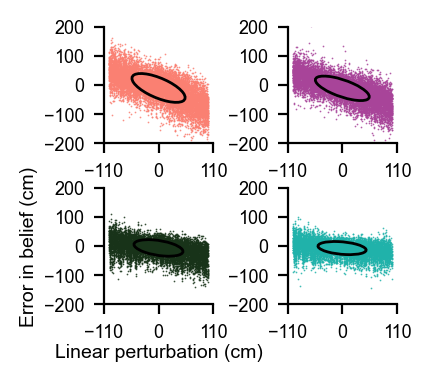

In [38]:
width = 2.1; height = 1.75
title_pad = 1.5
scatter_lw = 0.3; scatter_s = 0.5


xmax = 110; ymax = 200
xticks = np.linspace(-xmax, xmax, 3)
yticks = np.linspace(-ymax, ymax, 5)

colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]

with initiate_plot(width, height, 200) as fig:
    for f_idx in range(4):
        ax = fig.add_subplot(2, 2, f_idx + 1)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.xticks(xticks, fontsize=fontsize-0.5)
        plt.yticks(yticks, fontsize=fontsize-0.5)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim([-xmax, xmax])
        ax.set_ylim([-ymax, ymax])
        
        ax.scatter(perturb_sums_v[f_idx], decoding_errors_v[f_idx], 
                   c=colors[f_idx], lw=scatter_lw, s=scatter_s, marker='.', alpha=0.7)
        confidence_ellipse(perturb_sums_v[f_idx], decoding_errors_v[f_idx], ax, n_std=1, ec='k', lw=lw)
        
        if f_idx == 2:
            ax.set_xlabel(r'Linear perturbation (cm)', fontsize=fontsize)
            ax.set_ylabel(r'Error in belief (cm)', fontsize=fontsize)
            ax.xaxis.set_label_coords(0.5, -0.34)
            ax.yaxis.set_label_coords(-0.6, 0.5)
    
    fig.tight_layout(pad=0.1, w_pad=0, h_pad=0, rect=(-0.0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.png'.format(
    #    name='sup_pert_v_decoding_error_correlation'), orientation='portrait', format='png', transparent=True, dpi=2000)

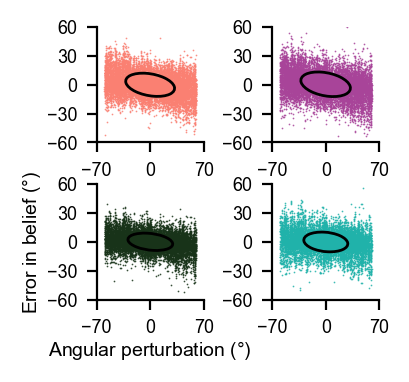

In [39]:
width = 1.95; height = 1.75
title_pad = 1.5
scatter_lw = 0.3; scatter_s = 0.5


xmax = 70; ymax = 60
xticks = np.linspace(-xmax, xmax, 3)
yticks = np.linspace(-ymax, ymax, 5)

colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]

with initiate_plot(width, height, 200) as fig:
    for f_idx in range(4):
        ax = fig.add_subplot(2, 2, f_idx + 1)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.xticks(xticks, fontsize=fontsize-0.5)
        plt.yticks(yticks, fontsize=fontsize-0.5)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim([-xmax, xmax])
        ax.set_ylim([-ymax, ymax])
        
        ax.scatter(perturb_sums_w[f_idx], decoding_errors_w[f_idx], 
                   c=colors[f_idx], lw=scatter_lw, s=scatter_s, marker='.', alpha=0.7)
        confidence_ellipse(perturb_sums_w[f_idx], decoding_errors_w[f_idx], ax, n_std=1, ec='k', lw=lw)
        
        if f_idx == 2:
            ax.set_xlabel(r'Angular perturbation ($\degree$)', fontsize=fontsize)
            ax.set_ylabel(r'Error in belief ($\degree$)', fontsize=fontsize)
            ax.xaxis.set_label_coords(0.5, -0.34)
            ax.yaxis.set_label_coords(-0.5, 0.5)
    
    fig.tight_layout(pad=0.1, w_pad=0.3, h_pad=-0.1, rect=(-0.0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.png'.format(
    #            name='sup_pert_w_decoding_error_correlation'), orientation='portrait',
    #            format='png', transparent=True, dpi=2000)

PearsonRResult(statistic=0.4486620532544217, pvalue=0.0)
0.8462941948472764
PearsonRResult(statistic=0.3992001891181389, pvalue=0.0)
0.9008891177470877
PearsonRResult(statistic=0.33856212238018873, pvalue=1.4154e-319)
0.8860443512176189
PearsonRResult(statistic=0.23330197146006934, pvalue=4.794810918017366e-148)
0.7039694868479632


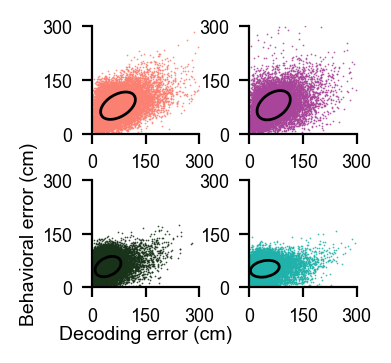

In [40]:
width = 1.8; height = 1.8
scatter_lw = 0.3; scatter_s = 0.5

xmax = 300; ymax = 300
xticks = np.linspace(0, xmax, 3)
yticks = np.linspace(0, ymax, 3)

titles = ['Holistic', 'Modular actor+\nHolistic critic', 'Holistic actor+\nModular critic', 'Modular']
colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
title_ys = [1.1, 1, 1, 1.1]

gain_idx = 2
start_idx = int(train_frac * len(agent_trajectories[0][gain_idx]))

with initiate_plot(width, height, 200) as fig:
    for f_idx in range(4):
        ax = fig.add_subplot(2, 2, f_idx + 1)
        ax.set_aspect('equal')
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.xticks(xticks, fontsize=fontsize-0.5)
        plt.yticks(yticks, fontsize=fontsize-0.5)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim([0, xmax])
        ax.set_ylim([0, ymax])
        
        decoding_errors = []; behavior_errors = []
        for seed_idx in range(8):
            df = agent_trajectories_all[f_idx][gain_idx][seed_idx].iloc[start_idx:]
            response = torch.stack([r[-1] for r in df.response])
            decoder = decoders_all[f_idx][gain_idx][seed_idx][0]
            predicted_position = decoder.predict(response)[:, :2]
            true_position = df[['pos_x_end', 'pos_y_end']].values
            decoding_error = np.linalg.norm(predicted_position - true_position, axis=1)
            behavior_error = df.relative_radius_end.values
            decoding_errors.append(decoding_error); behavior_errors.append(behavior_error)
        decoding_errors, behavior_errors = map(np.hstack, [decoding_errors, behavior_errors])
        
        ax.scatter(decoding_errors, behavior_errors, c=colors[f_idx], lw=scatter_lw, s=scatter_s, 
                   marker='.', alpha=0.7)
        confidence_ellipse(decoding_errors, behavior_errors, ax, n_std=1, ec='k', lw=lw)
        print(pearsonr(decoding_errors, behavior_errors))
        print(get_scatter_slope(decoding_errors, behavior_errors))
        
        if f_idx == 2:
            ax.set_ylabel(r'Behavioral error (cm)', fontsize=fontsize)
            ax.set_xlabel(r'Decoding error (cm)', fontsize=fontsize)
            ax.xaxis.set_label_coords(0.5, -0.35)
            ax.yaxis.set_label_coords(-0.5, 0.5)
    
    fig.tight_layout(pad=0, w_pad=-0.5, h_pad=-1, rect=(-0.01, 0, 0.99, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.png'.format(
    #    name='sup_correlation'), orientation='portrait', format='png', transparent=True, dpi=2000)